In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pycaret.regression import *

In [2]:
df=pd.read_csv('train-data.csv', index_col=0)

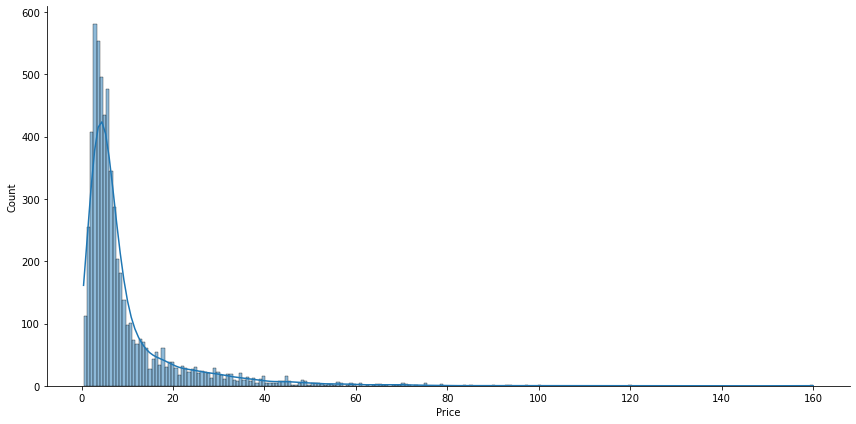

In [3]:
#Visualise the price data
ax = sns.displot(data=df, x='Price', kde=True, height=6, aspect=2)

### The shape of this graph suggests that there are many outliers at right tail which means there are some very expensive used cars in the market

# Data preprocessing

In [4]:
# Drop the column of 'New_Price' since it contains too many null values
df = df.drop(columns='New_Price')

# Drop null values
df.dropna(inplace=True)
df = df[df['Power'] != 'null bhp']

#Extract brand name from model name
df['Name'] = df['Name'].str.split().str[0]

#Data cleaning
df['Mileage'] = df['Mileage'].str.split().str[0].astype(float)
df['Engine'] = df['Engine'].str.split().str[0].astype(float)
df['Power'] = df['Power'].str.split().str[0].astype(float)
df['Year'] = df['Year'].astype(object)

#Log transform the price
df['Price'] = np.log(df['Price'])

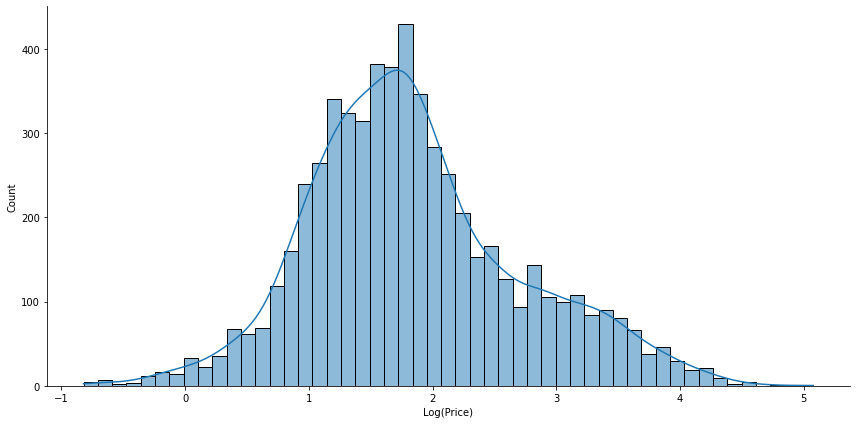

In [5]:
#Price after log transformation
ax = sns.displot(data=df, x='Price', kde=True, height=6, aspect=2)
ax.set(xlabel = 'Log(Price)')
plt.show()

In [6]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

In [7]:
reg = setup(train, target = 'Price', session_id=0)

,Description,Value
0,session_id,0
1,Target,Price
2,Original Data,"(4404, 12)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3082, 54)"


# Model comparison

In [8]:
best_model = compare_models(fold=5, include = ['lr', 'lasso', 'ridge', 'dt', 'rf', 'svm', 'ada', 'gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1539,0.0468,0.2162,0.9358,0.0860,0.1517,0.2220
gbr,Gradient Boosting Regressor,0.1655,0.0496,0.2227,0.9321,0.0859,0.1543,0.0580
ridge,Ridge Regression,0.1765,0.0726,0.2622,0.9033,0.0890,0.1512,0.2700
lr,Linear Regression,0.1781,0.0746,0.2652,0.9008,0.0897,0.1519,0.3880
dt,Decision Tree Regressor,0.2061,0.0841,0.2900,0.8844,0.1152,0.1867,0.0080
ada,AdaBoost Regressor,0.2721,0.1173,0.3423,0.8402,0.1279,0.2369,0.0420
svm,Support Vector Regression,0.6182,0.6469,0.8024,0.1234,0.2822,0.7168,0.0640
lasso,Lasso Regression,0.3826,0.6972,0.6987,0.1046,0.1822,0.4608,0.3160


# Model Training

In [9]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1460,0.0391,0.1976,0.9335,0.0782,0.1235
1,0.1428,0.0451,0.2124,0.9344,0.0850,0.1574
2,0.1517,0.0492,0.2217,0.9385,0.0891,0.1646
3,0.1521,0.0404,0.2011,0.9465,0.0831,0.1095
4,0.1501,0.0401,0.2003,0.9514,0.0882,0.1356
5,0.1556,0.0440,0.2098,0.9433,0.0801,0.1141
6,0.1605,0.0563,0.2372,0.9371,0.0976,0.2725
7,0.1457,0.0425,0.2062,0.9462,0.0746,0.1279
8,0.1486,0.0419,0.2048,0.9367,0.0835,0.2210
9,0.1527,0.0480,0.2190,0.9222,0.0824,0.1017


In [10]:
#tuned_rf = tune_model(rf, optimize = 'R2')

In [11]:
#plot_model(tuned_rf, plot = 'parameter')

# Insights from the model

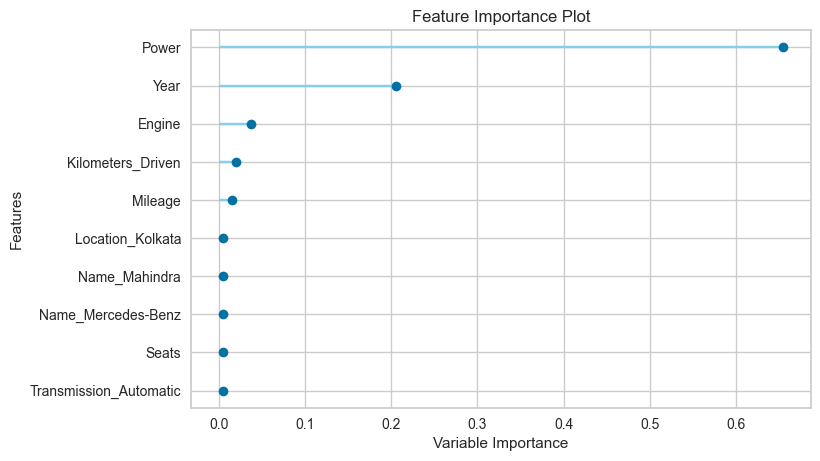

In [12]:
plot_model(rf, plot = 'feature')

## Residuals

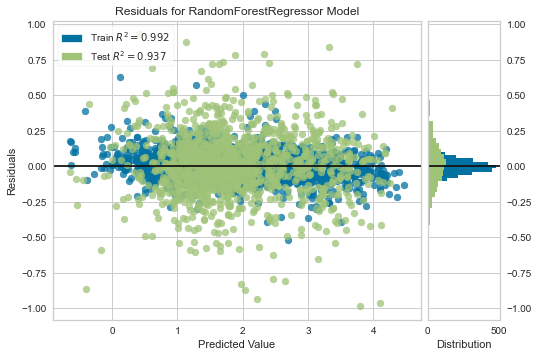

In [13]:
plot_model(rf, plot = 'residuals')

In [14]:
pred_holdouts = predict_model(rf)
pred_holdouts.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1606,0.0489,0.2212,0.9371,0.0850,0.1468


,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Name_Audi,Name_BMW,Name_Bentley,Name_Chevrolet,...,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Price,Label
0,2009.0,128000.0,10.800000,2497.0,215.000000,5.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.945910,2.448238
1,2010.0,144400.0,12.050000,2179.0,120.000000,8.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.658228,1.549247
2,2017.0,45000.0,16.299999,1956.0,170.000000,5.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.995732,2.932031
3,2015.0,48200.0,15.290000,1591.0,121.300003,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.197225,2.137818
4,2018.0,27413.0,20.510000,998.0,67.000000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.644805,1.545466


## Percentage Errors

In [15]:
pred_holdouts['Predicted Price'] = np.exp(pred_holdouts['Price'])
pred_holdouts['True Price'] = np.exp(pred_holdouts['Label'])

error_df = pred_holdouts[['Predicted Price', 'True Price']]
error_df['Error'] = error_df['Predicted Price'] - error_df['True Price']
error_df['Percentage Error'] = error_df['Error']/error_df['True Price']
error_df.sort_values(by=['Error'], ascending=False, inplace=True)
error_df

,Predicted Price,True Price,Error,Percentage Error
638,160.000000,60.845495,99.154505,1.629611
1282,120.000008,44.722617,75.277390,1.683206
628,92.999992,61.434215,31.565778,0.513814
782,78.999992,51.842244,27.157748,0.523854
985,67.000015,45.093891,21.906124,0.485789
...,...,...,...,...
400,21.000002,33.641904,-12.641902,-0.375778
879,31.749998,45.754230,-14.004232,-0.306075
1270,11.990000,27.718156,-15.728156,-0.567432
347,20.719997,42.727276,-22.007279,-0.515064


In [16]:
error_df['Predicted Price'] = error_df['Predicted Price']*0.88
error_df['Error'] = error_df['Predicted Price'] - error_df['True Price']
error_df['Percentage Error'] = error_df['Error']/error_df['True Price']

In [17]:
error_df.sort_values(by=['Error'], ascending=False, inplace=True)
error_df.head(20)

,Predicted Price,True Price,Error,Percentage Error
638,140.800003,60.845495,79.954508,1.314058
1282,105.600006,44.722617,60.877389,1.361222
628,81.839996,61.434215,20.405782,0.332157
782,69.519997,51.842244,17.677753,0.340991
692,39.600002,23.380062,16.219941,0.693751
387,45.759995,30.282581,15.477413,0.511100
205,28.160000,14.202245,13.957755,0.982785
985,58.960014,45.093891,13.866123,0.307494
1233,49.403206,35.866706,13.536500,0.377411
1190,20.679998,9.199280,11.480718,1.248002


In [18]:
np.percentile(error_df['Error'], 95)

2.0469856709797623

## Model Performance

In [19]:
rf_final = finalize_model(rf)

In [20]:
#Test set score
predictions = predict_model(rf_final, data = test)
r2_score(predictions['Price'], predictions['Label'])

0.9295001583941067

In [21]:
def pred_price(data):
    predictions = predict_model(rf_final, data = data)
    predictions['Price'] = predictions['Price'] * 0.88
    r2 = r2_score(predictions['Price'], predictions['Label'])
    
    return predictions, r2

In [22]:
predictions, r2 = pred_price(test)

In [23]:
predictions

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Label
4204,BMW,Chennai,2010,58000,Diesel,Automatic,First,16.46,2993.0,258.00,5.0,3.021909,2.900419
605,Mahindra,Ahmedabad,2015,73000,Diesel,Manual,First,16.00,2179.0,140.00,7.0,2.222641,2.377344
205,Audi,Delhi,2015,64103,Diesel,Automatic,First,15.73,1968.0,174.33,5.0,2.631833,3.059711
456,Maruti,Delhi,2018,12923,Diesel,Manual,First,25.10,1248.0,88.50,5.0,1.925700,2.158518
1303,BMW,Coimbatore,2012,44450,Diesel,Automatic,First,22.48,1995.0,190.00,5.0,2.821274,2.778738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,Toyota,Ahmedabad,2012,52100,Diesel,Manual,First,21.43,1364.0,86.79,5.0,1.647186,1.390231
3051,Mercedes-Benz,Delhi,2016,16000,Diesel,Automatic,First,11.30,2987.0,254.80,7.0,3.542309,4.148075
5135,Honda,Chennai,2016,14980,Diesel,Manual,First,27.30,1498.0,98.60,5.0,1.761302,1.924019
615,Toyota,Hyderabad,2017,52000,Diesel,Manual,First,13.68,2393.0,147.80,8.0,2.518737,2.895771


In [24]:
#Final score
r2

0.819027193715893